In [1]:
from pandeia.engine.calc_utils import build_default_calc
from pandeia.engine.perform_calculation import perform_calculation
from jwst_backgrounds import jbt
from matplotlib import pyplot as plt
import os
import subprocess
from astropy.io import fits
import numpy as np
from matplotlib import cm

In [130]:
configuration = build_default_calc("jwst", "nirspec", "ifu")

# The following is the template for the calculation of our prolate candidates. The values of the parameters
# are just for illustration and should be modified from object to object when doing real calculations.


ra = 40.0
dec = 35.0
background_primary_wavelength = 1.15 #micron
day_of_interest = 0 # The first day of visibility for the target sky coordinates in the current cycle.

sma = 7.5
smi = 1.5
Nser = 1.0
redshift = 1.0
Hmag = 20.0
Av = 0.4

# Calculate the sky background spectrum at the interested position.
bg = jbt.background(ra, dec, background_primary_wavelength)
wav, sky = bg.bkg_data['wave_array'], bg.bkg_data['total_bg'][day_of_interest] 


configuration['configuration']['scene_size'] = 40 # tentative, modify if errors up.
configuration['configuration']['detector'] = {'ngroup': 10, 'nint': 5, 'nexp': 1, 'subarray': 'full', 'readmode': 'nrsirs2'}
configuration['strategy'] = {'aperture_size': 30 , 'units': 'arcsec', 'background_subtraction': True,\
                             'method': 'ifunodinscene', "dithers":[{"x":0,"y":0}, {"x":1, "y":1}]}
# configuration['background'] = 'none'#JBT comes in.
configuration['background'] = []#JBT comes in.
configuration['background'].append(wav)
configuration['background'].append(sky)
configuration['background_level'] = 'low'
configuration['calculation']['effects']['background'] = True


scene = {}
scene['position'] = {'x_offset': 0., 'y_offset': 0, 'orientation': 0., \
                     'position_parameters': ['x_offset', 'y_offset', 'orientation']}
scene['shape'] = {'geometry': 'sersic', 'shape_parameters': ['major', 'minor', 'sersic_index'],\
#                   "major" and "minor" are actually "semi major/minor"!!!
                  'major': sma, 'minor': smi, 'sersic_index': Nser,\
                  'norm_method': 'integ_infinity'} #major and minor in arcseconds
scene['spectrum'] = {'name': 'Prolate Candidate', 'spectrum_parameters': ['sed', 'normalization', 'redshift']}
scene['spectrum']['sed'] = {'sed_type': 'brown', 'key': 'ngc_5953'} #remember to pick up an appropriate galaxy template.
scene['spectrum']['redshift'] = redshift
# ***Note***: I encountered a bug when I was trying to normalize the spectra with the HST/WFC3/F160W filter: in the
# $HOME/software/pandeia/normalization/config.json, there are no filenames specified for JWST and HST filters, and in
# $HOME/software/pandeia/normalization/bandpass, there are no filter curves for these two telescopes. Therefore I 
# copied the filter curve: $HOME/software/pysyn_cdbs/grp/hst/cdbs/comp/wfc3/wfc3_ir_f160w_005_syn.fits to the 
# $HOME/software/pandeia/normalization/bandpass, and added this file name to the config.json file. Keep this in mind!!!!
scene['spectrum']['normalization'] = {'type': 'hst', 'bandpass': 'wfc3,ir,f160w', 'norm_flux': Hmag, 'norm_fluxunit': 'abmag'}
scene['spectrum']['extinction'] = {'law': 'hd210121', 'value': Av, 'unit': 'mag', 'bandpass': 'v'}
configuration['scene'][0] = scene

In [131]:
configuration['configuration']['detector']['readmode'] = 'nrsirs2'
print(configuration['strategy'])

{'aperture_size': 30, 'units': 'arcsec', 'background_subtraction': True, 'method': 'ifunodinscene', 'dithers': [{'x': 0, 'y': 0}, {'x': 1, 'y': 1}]}


In [132]:
report = perform_calculation(configuration)

dict_keys(['sub_reports', 'input', '1d', '2d', '3d', 'scalar', 'information', 'transform', 'warnings'])
{'background_area': 266512.714509455, 'extraction_area': 266512.714509455, 'fraction_saturation': 0.0, 'sat_ngroups': 31.0, 'filter': 'f100lp', 'disperser': 'g140m', 'x_offset': 0.0, 'y_offset': 0.0, 'aperture_size': 30, 'sn': 0.0, 'extracted_flux': 0.0, 'extracted_noise': nan, 'background_total': 0.0, 'background_sky': 0.0, 'contamination': 0.0, 'reference_wavelength': 1.4310265526763641, 'background': 0.0, 'total_exposure_time': 7440.3339, 'all_dithers_time': 7440.3339, 'exposure_time': 3720.16695, 'measurement_time': 3282.5002499999996, 'saturation_time': 729.4445, 'total_integrations': 5, 'duty_cycle': 0.8823529411764706, 'cr_ramp_rate': 0.05788405765267828}
3.8681671409299314
60.30651774458893


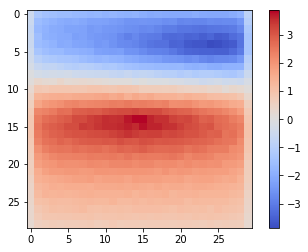

In [133]:
print(report.keys())
print(report['scalar'])
print(np.max(report['2d']['detector']))
print(np.max(report['2d']['snr']))
plt.imshow(report['2d']['detector'], cmap=cm.coolwarm)
plt.colorbar()

In [26]:
hdu = fits.open('/Users/zhanghaowen/software/pysyn_cdbs/grp/hst/cdbs/comp/wfc3/wfc3_ir_f160w_005_syn.fits')
hdu = fits.open('/Users/zhanghaowen/software/pandeia/normalization/bandpass/johnson_v_004_syn.fits')

In [27]:
hdu.info()

Filename: /Users/zhanghaowen/software/pandeia/normalization/bandpass/johnson_v_004_syn.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   ()      
  1                1 BinTableHDU     29   47R x 3C   [E, E, E]   


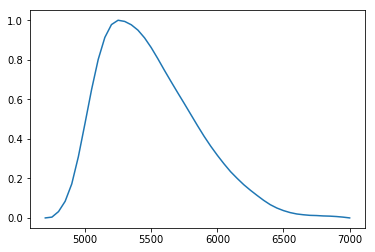

In [28]:
wav = [hdu[1].data[i][0] for i in range(len(hdu[1].data))]
amp = [hdu[1].data[i][1] for i in range(len(hdu[1].data))]
plt.plot(wav,amp)

In [20]:
print(hdu[1].data.transpose())

[( 7450.052 , 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00)
 ( 7451.052 , 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00)
 ( 7452.052 , 9.9010962e-05, 9.9010962e-05, 9.9010962e-05, 9.9010962e-05, 9.9010962e-05)
 ( 7502.0654, 9.8981232e-05, 9.8981232e-05, 9.8981232e-05, 9.8981232e-05, 9.8981232e-05)
 ( 7552.0786, 1.9794265e-04, 1.9794265e-04, 1.9794265e-04, 1.9794265e-04, 1.9794265e-04)
 ( 7602.0923, 1.9794265e-04, 1.9794265e-04, 1.9794265e-04, 1.9794265e-04, 1.9794265e-04)
 ( 7652.106 , 2.4740351e-03, 2.4740351e-03, 2.4740351e-03, 2.4740351e-03, 2.4740351e-03)
 ( 7702.119 , 2.0795374e-03, 2.0795374e-03, 2.0795374e-03, 2.0795374e-03, 2.0795374e-03)
 ( 7752.133 , 1.3866887e-03, 1.3866887e-03, 1.3866887e-03, 1.3866887e-03, 1.3866887e-03)
 ( 7802.146 , 1.9804174e-04, 1.9804174e-04, 1.9804174e-04, 1.9804174e-04, 1.9804174e-04)
 (10002.741 , 9.9030789e-05, 9.9030789e-05, 9.9030789e-05, 9.9030789e-05, 9.9030789e-05)
 (13603.719 , 9.90704